In [15]:
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.notebook import tqdm

%matplotlib inline
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()
sns.set()

# Tensorboard extension (for visualization purposes later)
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/tutorial9")

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch.set_float32_matmul_precision('medium')
print("Device:", device)

C:\Users\Corrado Mio\AppData\Local\Temp\ipykernel_5940\1513918759.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export
Global seed set to 42


Device: cuda:0


In [16]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial9/"
# Files to download
pretrained_files = ["cifar10_64.ckpt", "cifar10_128.ckpt", "cifar10_256.ckpt", "cifar10_384.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the files manually,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

In [17]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)


def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


In [18]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """
        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(2 * 16 * c_hid, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

In [19]:
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """
        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * 16 * c_hid), act_fn())
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 16x16 => 32x32
            nn.Tanh(),  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [20]:
class Autoencoder(pl.LightningModule):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 3,
        width: int = 32,
        height: int = 32,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)"""
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)

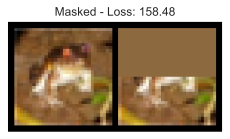

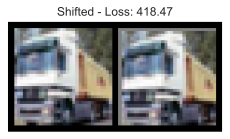

In [21]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4, 2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()


for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1, 2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:, :1, :] = img_mean
    img_shifted[:, :, :1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:, : img_masked.shape[1] // 2, :] = img_mean
    compare_imgs(img, img_masked, "Masked -")

In [22]:
class GenerateCallback(pl.Callback):
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1, 1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [23]:
def train_cifar(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "cifar10_%i" % latent_dim),
        gpus=1 if str(device).startswith("cuda") else 0,
        max_epochs=500,
        callbacks=[
            ModelCheckpoint(save_weights_only=True),
            GenerateCallback(get_train_images(8), every_n_epochs=10),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "cifar10_%i.ckpt" % latent_dim)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [24]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_cifar(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

D:\Python\Anaconda3-2022.05\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v1.9.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file D:\Projects.github\python_projects\check_torch\saved_models\tutorial9\cifar10_64.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v1.9.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file D:\Projects.github\python_projects\check_torch\saved_models\tutorial9\cifar10_128.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v1.9.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file D:\Projects.github\python_projects\check_torch\saved_models\tutorial9\cifar10_256.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v1.9.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file D:\Projects.github\python_projects\check_torch\saved_models\tutorial9\cifar10_384.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [25]:
latent_dims = sorted(k for k in model_dict)
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    latent_dims, val_scores, "--", color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16
)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0, 100)
plt.show()

In [26]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7, 4.5))
    plt.title("Reconstructed from %i latents" % (model.hparams.latent_dim))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

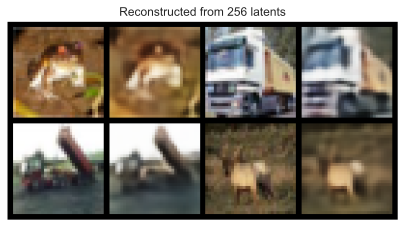

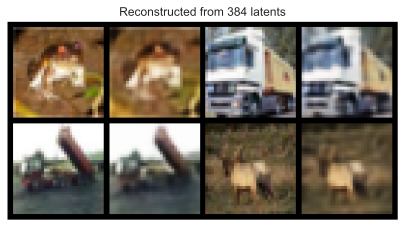

In [27]:
input_imgs = get_train_images(4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

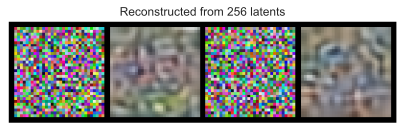

In [28]:
rand_imgs = torch.rand(2, 3, 32, 32) * 2 - 1
visualize_reconstructions(model_dict[256]["model"], rand_imgs)

D:\Python\Anaconda3-2022.05\envs\torch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


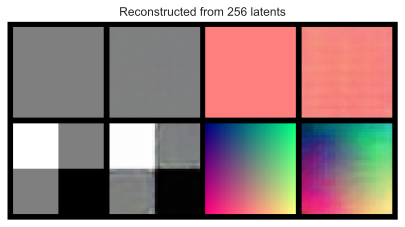

In [29]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Single color channel
plain_imgs[1, 0] = 1
# Checkboard pattern
plain_imgs[2, :, :16, :16] = 1
plain_imgs[2, :, 16:, 16:] = -1
# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1, 1, 32), torch.linspace(-1, 1, 32))
plain_imgs[3, 0, :, :] = xx
plain_imgs[3, 1, :, :] = yy

visualize_reconstructions(model_dict[256]["model"], plain_imgs)

In [30]:
model = model_dict[256]["model"]
latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)
with torch.no_grad():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1, 1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8, 5))
plt.imshow(grid)
plt.axis("off")
plt.show()

In [31]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
model = model_dict[128]["model"]

In [32]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))


train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)

Encoding images:   0%|          | 0/175 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/40 [00:00<?, ?it/s]

In [33]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None, :], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K + 1, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

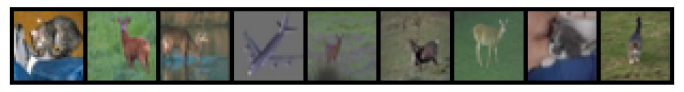

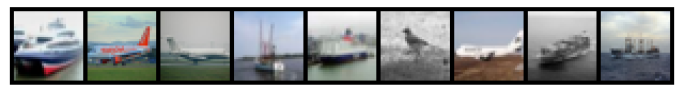

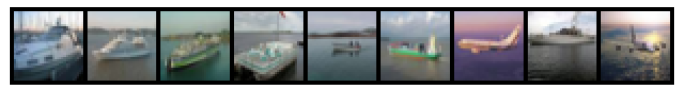

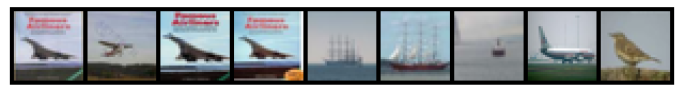

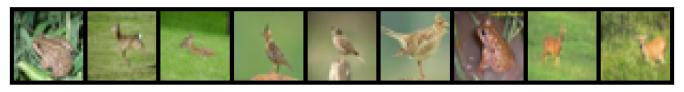

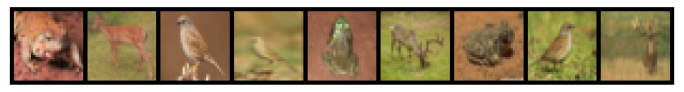

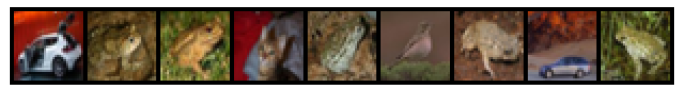

In [34]:
# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)